In [1]:
import pandas as pd
from typing import Type
import sys
from typing import Dict

sys.path.append("..")
from utils import print_memory_stats, get_memory_stats

file_name = "automotive.csv.zip"
column_types_name = "column_types.pkl"
ten_columns_name = "10_columns.csv"

column_info_dict: Dict[str, Dict] = {}

unique_values_dict: Dict[str, set] = {}

number_of_values: Dict[str, int] = {}

chunk_generator = pd.read_csv(file_name, chunksize=1_000_000, compression="zip")

total_memory_usage = {}

objects = []

for i, chunk in enumerate(chunk_generator):
    for column in chunk.columns:
        if column not in column_info_dict:
            column_info_dict[column] = {
                "memory_usage": 0,
                "memory_percent": 0,
                "dtype": chunk[column].dtype,
            }

        column_info_dict[column]["memory_usage"] += (
            chunk[column].memory_usage(deep=True) // 1024
        )

        if chunk[column].dtype == "object":
            objects.append(column)
            if column not in unique_values_dict:
                unique_values_dict[column] = set()

            unique_values_dict[column].update(chunk[column].unique())
            number_of_values[column] = (
                number_of_values.get(column, 0) + chunk[column].count()
            )

/tmp/ipykernel_33697/2813855079.py:25: DtypeWarning: Columns (1,8,9,17,22,25,26,32,37,53,65,67,69,70,91,93,107,111,120,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):
/tmp/ipykernel_33697/2813855079.py:25: DtypeWarning: Columns (1,8,9,17,18,26,32,37,53,65,67,69,79,91,93,107,111,120,122,133) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):
/tmp/ipykernel_33697/2813855079.py:25: DtypeWarning: Columns (1,8,9,17,18,25,26,32,37,45,53,65,67,69,91,93,107,111,120,122,133) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):
/tmp/ipykernel_33697/2813855079.py:25: DtypeWarning: Columns (1,8,9,17,18,25,26,32,37,45,53,65,67,69,91,93,107,111,113,120,122,133) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):
/tmp/ipyker

In [2]:
import os

total_memory = sum(info["memory_usage"] for info in column_info_dict.values())
for column, info in column_info_dict.items():
    info["memory_percent"] = (info["memory_usage"] / total_memory) * 100

column_info_df = pd.DataFrame.from_dict(column_info_dict, orient="index")
file_size = {"file_size_KB": os.path.getsize(file_name) // 1024}
in_memory_size = {"file_in_memory_size_KB": total_memory}

print_memory_stats(file_size, in_memory_size, column_info_df, "mem_res_no_opt.json")

In [3]:
chunk_generator = pd.read_csv(file_name, chunksize=1_000_000, compression="zip")

num_unique_values = {
    column: len(values) for column, values in unique_values_dict.items()
}

isFirst = True
types = {}

dfs = []
for i, chunk in enumerate(chunk_generator):
    for column in chunk.columns:
        if not isFirst:
            chunk[column] = chunk[column].astype(types[column])
        if column in objects:
            if num_unique_values[column] / number_of_values[column] < 0.5:
                chunk[column] = chunk[column].astype("category")
            else:
                chunk[column] = chunk[column].astype("object")
        elif isFirst and pd.api.types.is_integer_dtype(chunk[column]):
            chunk[column] = pd.to_numeric(chunk[column], downcast="unsigned")
        elif isFirst and pd.api.types.is_float_dtype(chunk[column]):
            chunk[column] = pd.to_numeric(chunk[column], downcast="float")
        else:
            continue
    if isFirst:
        types = chunk.dtypes.to_dict()
        isFirst = False
    print(chunk.info(memory_usage="deep"))
    dfs.append(chunk)

combined_df = pd.concat(dfs, ignore_index=True, sort=False)

/tmp/ipykernel_33697/2164833578.py:11: DtypeWarning: Columns (1,8,9,17,22,25,26,32,37,53,65,67,69,70,91,93,107,111,120,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 156 entries, vin to vf_Windows
dtypes: bool(1), category(98), float32(52), object(1), uint16(1), uint32(3)
memory usage: 519.0 MB
None


/tmp/ipykernel_33697/2164833578.py:11: DtypeWarning: Columns (1,8,9,17,18,26,32,37,53,65,67,69,79,91,93,107,111,120,122,133) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 1000000 to 1999999
Columns: 156 entries, vin to vf_Windows
dtypes: bool(1), category(98), float32(52), object(1), uint16(1), uint32(3)
memory usage: 519.0 MB
None


/tmp/ipykernel_33697/2164833578.py:11: DtypeWarning: Columns (1,8,9,17,18,25,26,32,37,45,53,65,67,69,91,93,107,111,120,122,133) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 2000000 to 2999999
Columns: 156 entries, vin to vf_Windows
dtypes: bool(1), category(98), float32(52), object(1), uint16(1), uint32(3)
memory usage: 519.0 MB
None


/tmp/ipykernel_33697/2164833578.py:11: DtypeWarning: Columns (1,8,9,17,18,25,26,32,37,45,53,65,67,69,91,93,107,111,113,120,122,133) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 3000000 to 3999999
Columns: 156 entries, vin to vf_Windows
dtypes: bool(1), category(98), float32(52), object(1), uint16(1), uint32(3)
memory usage: 519.0 MB
None


/tmp/ipykernel_33697/2164833578.py:11: DtypeWarning: Columns (1,8,9,17,25,26,32,37,45,53,65,67,69,91,93,107,111,120,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 4000000 to 4999999
Columns: 156 entries, vin to vf_Windows
dtypes: bool(1), category(98), float32(52), object(1), uint16(1), uint32(3)
memory usage: 519.0 MB
None


/tmp/ipykernel_33697/2164833578.py:11: DtypeWarning: Columns (1,8,9,17,18,25,26,32,37,53,65,67,69,79,91,107,111,113,120,122,133,144) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_generator):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695015 entries, 5000000 to 5695014
Columns: 156 entries, vin to vf_Windows
dtypes: bool(1), category(98), float32(52), object(1), uint16(1), uint32(3)
memory usage: 408.5 MB
None


In [4]:
combined_df.info(memory_usage="deep")
memory_stats = get_memory_stats(combined_df, file_name)
print_memory_stats(
    memory_stats[0], memory_stats[1], memory_stats[2], "mem_res_opt.json"
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5695015 entries, 0 to 5695014
Columns: 156 entries, vin to vf_Windows
dtypes: bool(1), category(98), float32(52), object(1), uint16(1), uint32(3)
memory usage: 2.2 GB


In [8]:
from zipfile import ZipFile


def save_10_columns(my_df: pd.DataFrame):
    column_names = [
        "vin",
        "brandName",
        "modelName",
        "msrp",
        "isNew",
        "askPrice",
        "mileage",
        "vf_ABS",
        "vf_Doors",
        "vf_EngineHP",
    ]
    types = my_df.dtypes.to_dict()
    first_chunk = True
    for chunk in pd.read_csv(
        file_name,
        usecols=lambda x: x in column_names,
        dtype=types,
        chunksize=1_000_000,
    ):
        chunk.to_csv(
            ten_columns_name,
            mode="w" if first_chunk else "a",
            header=first_chunk,
            index=False,
        )
        first_chunk = False
        print("chunk added")

    compression_options = dict(method="zip", archive_name=column_types_name)
    pd.to_pickle(types, f"{column_types_name}.zip", compression=compression_options)


save_10_columns(combined_df)

with ZipFile(f"{ten_columns_name}.zip", "w") as myzip:
    myzip.write(ten_columns_name)

loaded_column_types = pd.read_pickle(f"{column_types_name}.zip", compression="zip")
df = pd.read_csv(
    f"{ten_columns_name}.zip", dtype=loaded_column_types, compression="zip"
)
df

chunk added
chunk added
chunk added
chunk added
chunk added
chunk added


,vin,msrp,askPrice,mileage,isNew,brandName,modelName,vf_ABS,vf_Doors,vf_EngineHP
0,abc5f0360059cf7b6fa8368db57f220ab0d87d582bf6ce...,1498,1498,0,False,MITSUBISHI,Eclipse Spyder,NaN,2.0,NaN
1,e24402cc77f6fd2d6a9dd626ad92795b717814340f1ab1...,10589,10589,0,False,NISSAN,Altima,NaN,4.0,NaN
2,1c5a8dc966b3d3b379e10477d9ff8a8aa13edf43acc7f7...,11992,9940,0,False,FORD,Escape,NaN,4.0,178.0
3,edce23814c88f5a1d1af700c27ad7f4c9d705aa9873317...,12387,12387,0,False,CHEVROLET,Cruze,Standard,4.0,NaN
4,6b4f8c610d14d864f024adb26cd4f0eddcff3fa18c16e3...,41659,41659,0,True,FORD,F-150,Standard,NaN,395.0
...,...,...,...,...,...,...,...,...,...,...
5695010,NaN,34177,33388,7366,False,LAND ROVER,Discovery Sport,Standard,5.0,237.0
5695011,NaN,49776,46492,5844,False,LAND ROVER,Range Rover Evoque,Standard,5.0,296.0
5695012,NaN,61000,54999,20737,False,MERCEDES-BENZ,GLS-Class,Standard,4.0,362.0
5695013,NaN,24240,21709,0,True,NISSAN,Kicks,NaN,4.0,NaN


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CHEVROLET'),
  Text(1, 0, 'FORD'),
  Text(2, 0, 'TOYOTA'),
  Text(3, 0, 'JEEP'),
  Text(4, 0, 'NISSAN'),
  Text(5, 0, 'HONDA'),
  Text(6, 0, 'HYUNDAI'),
  Text(7, 0, 'GMC'),
  Text(8, 0, 'DODGE'),
  Text(9, 0, 'VOLKSWAGEN')])

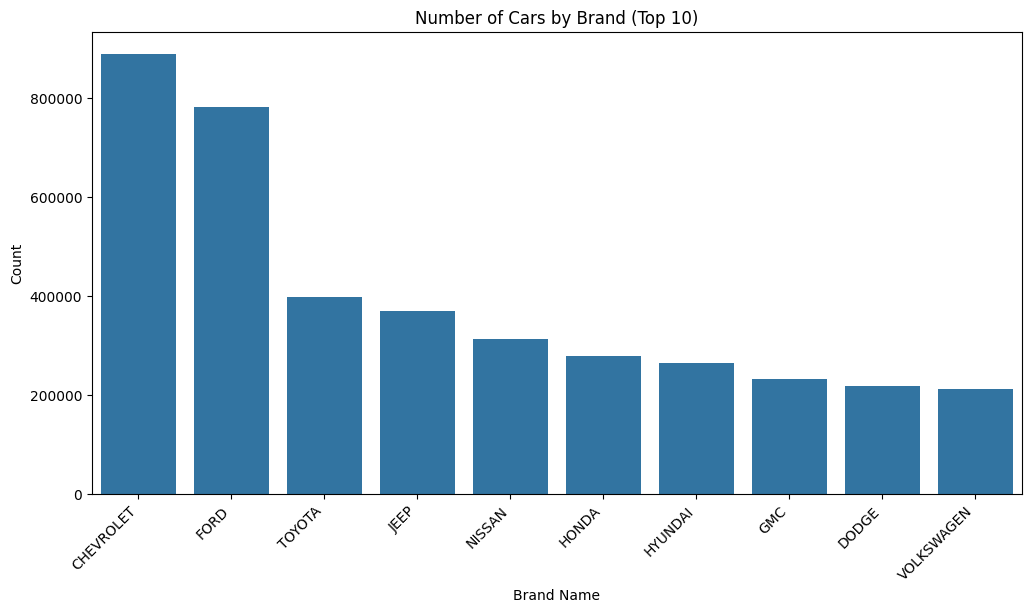

In [10]:
top_brands = df["brandName"].value_counts().nlargest(10).index

df_top_brands = df[df["brandName"].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.countplot(x="brandName", data=df_top_brands, order=top_brands)
plt.title("Number of Cars by Brand (Top 10)")
plt.xlabel("Brand Name")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

Text(0, 0.5, '')

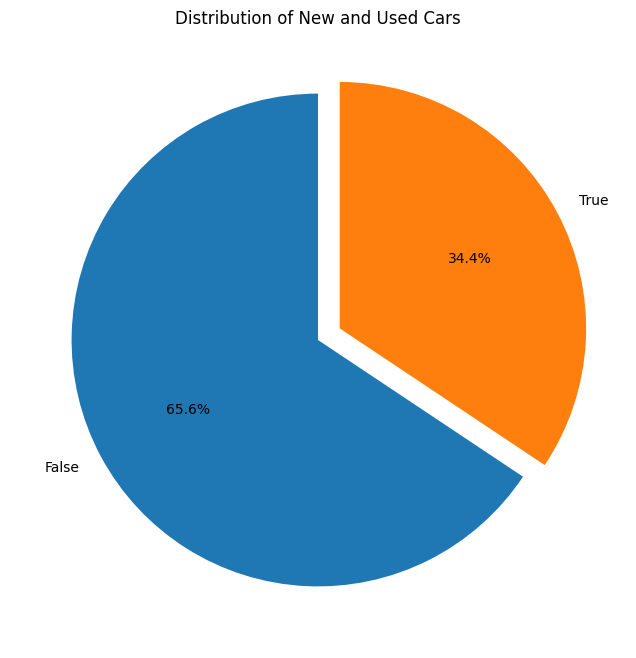

In [11]:
plt.figure(figsize=(8, 8))
df["isNew"].value_counts().plot.pie(autopct="%1.1f%%", startangle=90, explode=[0, 0.1])  # type: ignore
plt.title("Distribution of New and Used Cars")
plt.ylabel("")

Text(0, 0.5, 'Frequency')

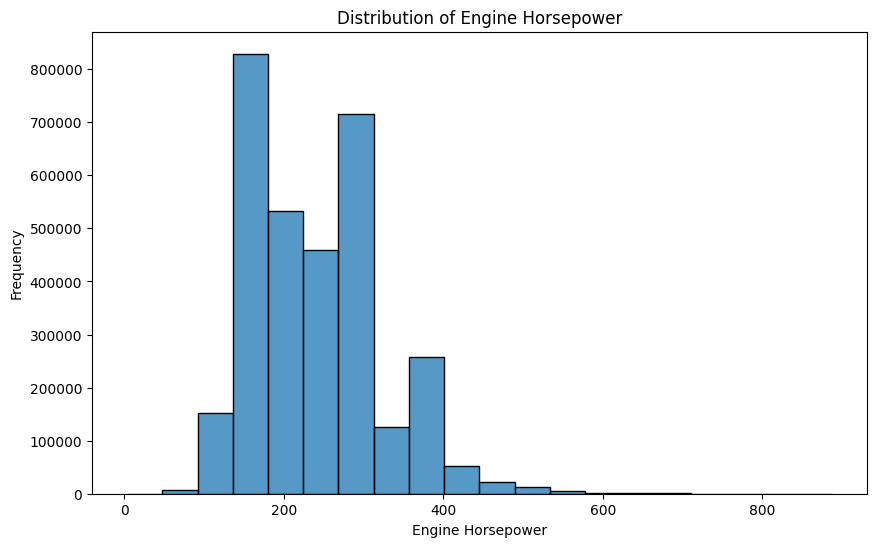

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df["vf_EngineHP"], bins=20, kde=False)
plt.title("Distribution of Engine Horsepower")
plt.xlabel("Engine Horsepower")
plt.ylabel("Frequency")

/tmp/ipykernel_33697/1287712715.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["vf_Doors"] = pd.to_numeric(df_selected["vf_Doors"], errors="coerce")


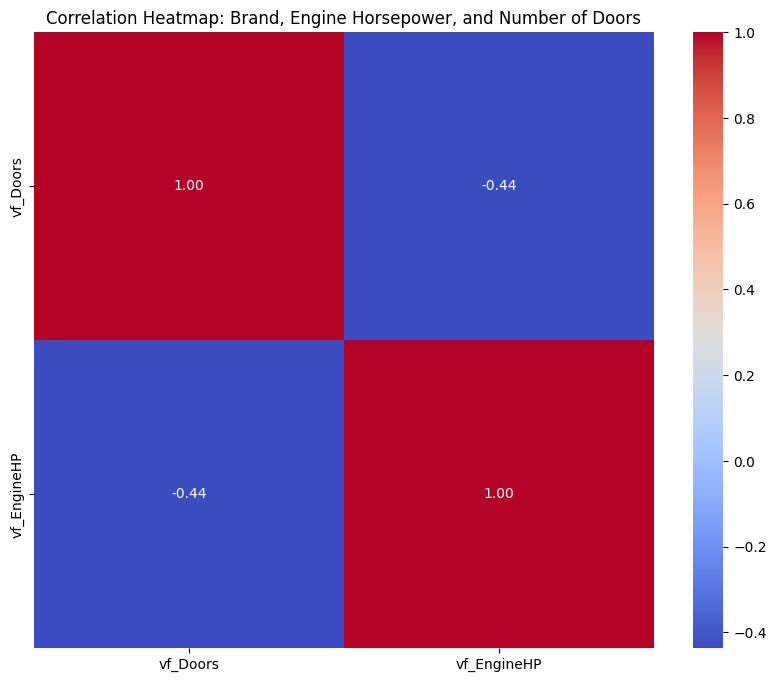

In [13]:
selected_columns = ["brandName", "vf_EngineHP", "vf_Doors"]
df_selected = df[selected_columns]

df_selected["vf_Doors"] = pd.to_numeric(df_selected["vf_Doors"], errors="coerce")

correlation_data = df_selected.pivot_table(index="brandName", aggfunc="mean")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Brand, Engine Horsepower, and Number of Doors")
plt.show()

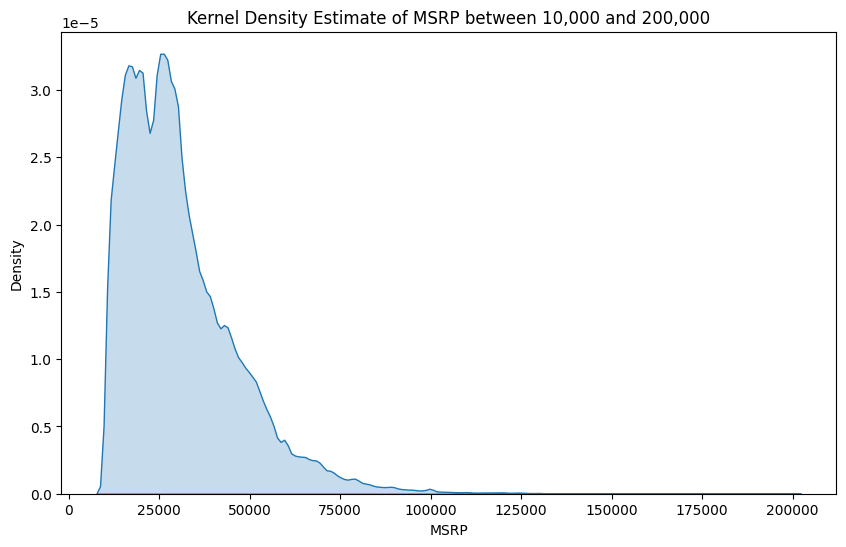

In [14]:
df_filtered_msrp = df[(df["msrp"] >= 10000) & (df["msrp"] <= 200000)]

plt.figure(figsize=(10, 6))
sns.kdeplot(df_filtered_msrp["msrp"], fill=True)
plt.title("Kernel Density Estimate of MSRP between 10,000 and 200,000")
plt.xlabel("MSRP")
plt.ylabel("Density")
plt.show()